In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn import datasets
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import entropy

In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    
    for tree_idx, tree in enumerate(model):
        
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        for vote_index in vote_indices:
            class_counts[tree.apply(X[vote_index].reshape(1, -1)).item(), y[vote_index]] += 1
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        where_empty = np.argwhere(class_probs.sum(axis = 1) == 0)
        for elem in where_empty:
            class_probs[elem] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy = np.mean(eval_entropies)
        
        return cond_entropy

In [5]:
def generate_data(n):
    
    # Class sizes.
    n_0 = np.random.binomial(n, 0.5, 1)[0]
    n_1 = n - n_0
    
    # Generate uniform spiral.
    theta = np.random.uniform(0.0, 5*np.pi, size=n_0).reshape(-1, 1) # TODO change to uniform sampling.
    X_0 = np.concatenate((2*np.cos(theta), 2*np.sin(theta), 5*theta / np.pi - 10), axis = 1)
    y_0 = np.repeat(0, n_0)
    
    # Generate fuzzy stick.
    sigma = 0.05
    zeros = np.zeros((n_1, 1))
    X_1 = np.concatenate((zeros, zeros, np.random.uniform(-10, 10, n_1).reshape(-1, 1)), axis = 1)
    X_1 += np.random.multivariate_normal(np.zeros(3), sigma*np.eye(3), n_1)
    y_1 = np.repeat(1, n_1)
    
    X = np.concatenate((X_0, X_1), axis = 0)
    y = np.concatenate((y_0, y_1), axis = 0)                  
    
    return X, y

In [6]:
def plot_setting(X, y):
    colors = np.array(["#2166ac", "#c51b7d"])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca(projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], s=100, c=colors[y], depthshade=True)

    # Remove background.
    # Get rid of colored axes planes
    # First remove fill
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    # ax.grid(False)

    plt.savefig("fig6_3D.pdf")
    plt.show()

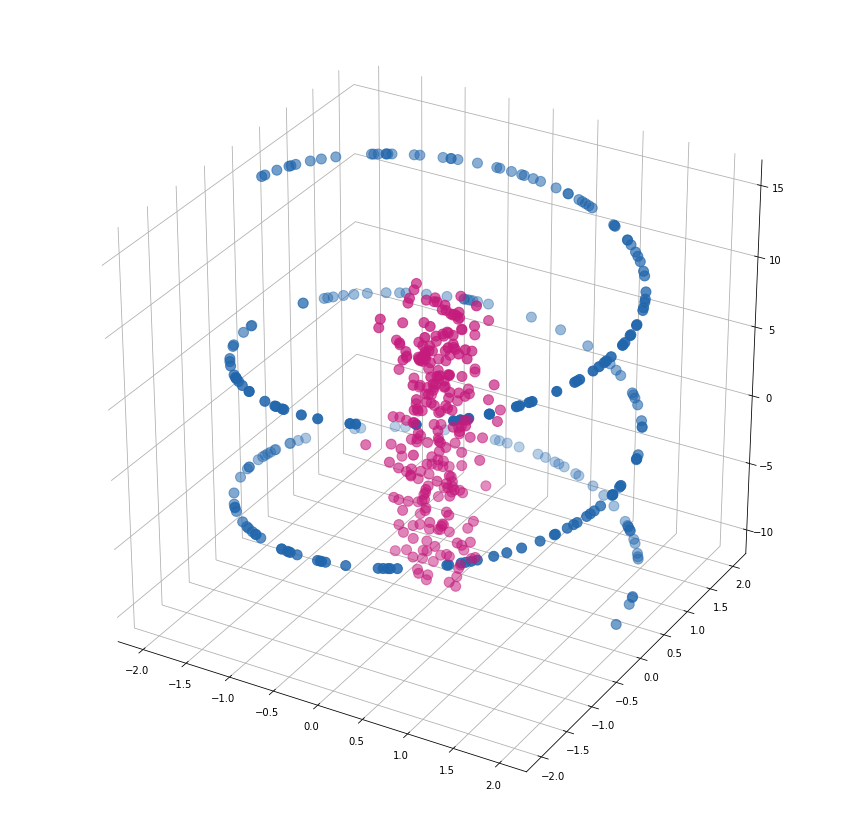

In [7]:
n = 500

X, y = generate_data(n)
plot_setting(X, y)

In [8]:
def estimate_mi(X, y, label):
    
    _, counts = np.unique(y, return_counts=True)
    est_H_Y = entropy(counts, base=np.exp(1))
    
    if label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return est_H_Y - np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF":
        return est_H_Y - uf(np.array(X), y)
    elif label == "KSG":
        return mixed.KSG(X, y.reshape(-1, 1)) 
    elif label == "Mixed KSG":
        return mixed.Mixed_KSG(X, y.reshape(-1, 1))
    else:
        raise ValueError("Unrecognized Label!")

In [9]:
def get_mutual_info_by_n(num_trials, sample_sizes, algos):
    
    def worker(t):
        X, y = generate_data(elem)
        
        ret = []
        for algo in algos:
            ret.append(estimate_mi(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(sample_sizes), num_trials))
    for i, elem in enumerate(sample_sizes):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
    pickle.dump(sample_sizes, open('sample_sizes.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_n.pkl' % algo['label'], 'wb'))
        
    return output

In [10]:
# Real params.
sample_sizes = range(200, 1001, 80)
num_trials = 20
num_plotted_trials = 5

# Fake params
# sample_sizes = range(150, 180, 10)
# num_trials = 3
# num_plotted_trials = 2

# Algorithms.
algos = [
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'KSG',
        'title': 'KSG',
        'color': "#1b9e77",
    },
    {
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "purple",
    },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

In [11]:
get_mutual_info_by_n(num_trials, sample_sizes, algos)

array([[[0.6142766 , 0.6711095 , 0.66717314, 0.65867639, 0.64020811,
         0.67697922, 0.60716513, 0.64132193, 0.6549352 , 0.67380041,
         0.67175645, 0.61709569, 0.65149947, 0.61070537, 0.63901346,
         0.64096232, 0.65828154, 0.65848769, 0.6550408 , 0.66705546],
        [0.65618151, 0.6762909 , 0.66845674, 0.63110514, 0.68042268,
         0.65304059, 0.64406201, 0.65739097, 0.63187709, 0.62663509,
         0.6601882 , 0.67947119, 0.67402777, 0.65585186, 0.64210254,
         0.66361809, 0.6413504 , 0.66166008, 0.6292339 , 0.66384852],
        [0.6703552 , 0.65233782, 0.67069283, 0.6393028 , 0.67816975,
         0.65666729, 0.67180586, 0.6698708 , 0.65463068, 0.66092206,
         0.66977343, 0.67402806, 0.66576613, 0.65393116, 0.67240481,
         0.67625533, 0.67537247, 0.67103472, 0.65984477, 0.66073264],
        [0.68288237, 0.65323972, 0.6688685 , 0.67013006, 0.67942733,
         0.67188839, 0.66040383, 0.66926289, 0.68390136, 0.65986256,
         0.65526739, 0.67195156

In [12]:
def plot_mutual_info_by_n(ax, num_plotted_trials, algos):
        
    sample_sizes = np.array(pickle.load(open('sample_sizes.pkl', 'rb')))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_n.pkl' % algo['label'], 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    result[:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
        
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated MI")
    ax.set_title("Fuzzy Stick and Spiral Mutual Info")

In [13]:
def plot_fig5(num_plotted_trials, algos):
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [10, 10]
    fig, ax = plt.subplots(1, 1)
    
    plot_mutual_info_by_n(ax, num_plotted_trials, algos)

    plt.tight_layout()
    plt.savefig("fig6.pdf")
    plt.show()

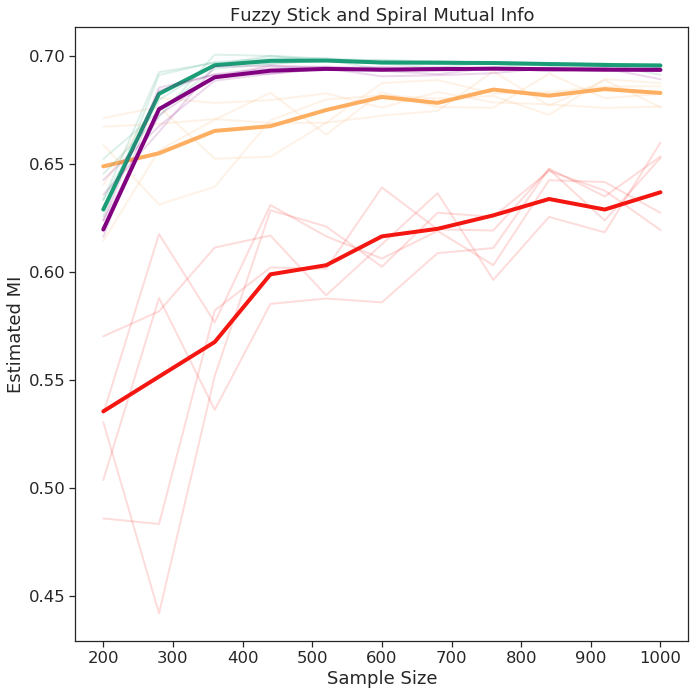

In [14]:
plot_fig5(num_plotted_trials, algos)